In [168]:
import gym
from gym.spaces.utils import flatdim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from copy import deepcopy

In [169]:
class FrozenLakeModel:
    def __init__(self, transitions):
        self.model = transitions

    def step(self, obs, action):
        return self.model[obs][action][0]
    
    def actions(self, obs):
        return list(self.model[obs].keys())

class Node:
    def __init__(self, state, action=None):
        self.state = state
        self.action = action
        self.reward = 0
        self.done = False

        self.parent = None
        self.children = {}

        self.value = 0.0
        self.visits = 0
    
    def __repr__(self):
        return f"Node: (s:{self.state}, a:{self.action}, r:{self.reward}, d:{self.done})"
    
    def update_stats(self, val):
        self.visits += 1
        self.value += (val - self.value) / float(self.visits)

class MCTS:
    def __init__(self, cur_state, model, hparams):
        self.cur_state = cur_state
        self.model: FrozenLakeModel = model
        self.iters: int = hparams["iters"]
        self.discount = 0.99 
        self.sim_depth = 1000
    
    def search(self):
        root = Node(self.cur_state)
        for i in range(self.iters):
            next_node = self._treePolicy(root)
            reward = self._rolloutPolicy(next_node)
            self._backup(next_node, reward)
        
        return self._best_action(root), root

    def _best_action(self, root):
        return max(root.children.values(), key = lambda child: child.visits).action

    # Tree Policy explores current tree up to edge.
    def _treePolicy(self, cur_node) -> Node:

        next_node = cur_node
        while not next_node.done:
            if not self._expanded(next_node):
                return self._expand(next_node)
            else:
                next_node = self._UCT(next_node)

        return next_node

    # Rollout policy performs random (or via some policy) rollouts til termination. Returns reward.
    def _rolloutPolicy(self, node: Node) -> float:
        
        cur_node = node
        done = False
        cum_reward = node.reward
        for _ in range(self.sim_depth):
            action = np.random.choice(self.model.actions(cur_node.state))
            _, next_obs, r, done = self.model.step(cur_node.state, action) 

            cum_reward += r
            if done:
                break
                
            cur_node = Node(next_obs)
        return cum_reward

    def _UCT(self, node: Node) -> Node:
        children: list[Node] = list(node.children.values())
        weights = [child.value + 1.5 * np.sqrt(np.log(node.visits + 1e-6) / (child.visits + 1e-6)) for child in children]
        weights = np.array(weights) / sum(weights)
        return np.random.choice(children, p=weights)

    def _expanded(self, node: Node) -> bool:
        return set(self.model.actions(node.state)) == set(node.children.keys())

    def _expand(self, node: Node) -> Node:

        # Sample random action
        actions = self.model.actions(node.state)
        if (len(node.children.keys()) > 0):
            for performed in list(node.children.keys()):
                actions.remove(performed)

        action = np.random.choice(actions)

        _, next_obs, r, done = self.model.step(node.state, action)

        # Construct new node
        next_node = Node(next_obs, action)
        next_node.parent = node
        next_node.reward = r
        next_node.done = done

        # Add to list of children
        node.children[action] = next_node

        return next_node



    def _backup(self, node: Node, reward: float) -> None:
        node.update_stats(reward)

        while node.parent:
            node = node.parent
            node.update_stats(self.discount * reward)



In [178]:
env = gym.make("FrozenLake-v1", is_slippery=False)
model = FrozenLakeModel(env.P)
obs = env.reset()

action_map = {
    0: "LEFT",
    1: "DOWN", 
    2: "RIGHT",
    3: "UP"
}

obs = env.reset()
done = False
ep_r = 0
while not done:
    action, values = MCTS(obs, model, {"iters": 1000}).search()
    # print([(action_map[child.action], child.value) for child in values.children.values()])
    # print(f"Moving {action_map[action]}")
    obs, r, done, _ = env.step(action)
    env.render()
    
    print(obs, r, done)

    ep_r += r

print(f"Episode return: {ep_r}")

  (Up)
SFFF
FHFH
FFFH
HFFG
0 0.0 False
  (Up)
SFFF
FHFH
FFFH
HFFG
0 0.0 False
  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False
  (Left)
SFFF
FHFH
FFFH
HFFG
4 0.0 False
  (Left)
SFFF
FHFH
FFFH
HFFG
4 0.0 False
  (Down)
SFFF
FHFH
FFFH
HFFG
8 0.0 False
  (Right)
SFFF
FHFH
FFFH
HFFG
9 0.0 False
  (Down)
SFFF
FHFH
FFFH
HFFG
13 0.0 False
  (Right)
SFFF
FHFH
FFFH
HFFG
14 0.0 False
  (Right)
SFFF
FHFH
FFFH
HFFG
15 1.0 True
Episode return: 1.0


100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


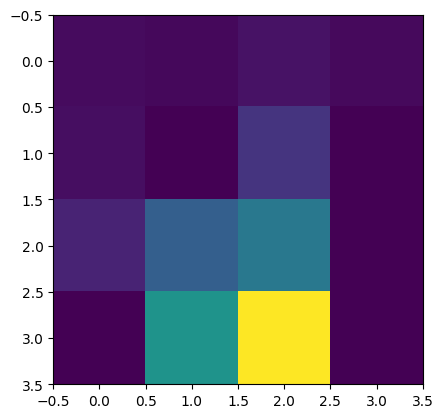

In [171]:
# MCTS estimated values in every state
nS = flatdim(env.observation_space)
V = np.zeros(nS)
for i in trange(env.observation_space.n):
    _, values = MCTS(i, model, {"iters": 5000}).search()
    V[i] = np.mean([child.value for child in values.children.values()])

plt.imshow(V.reshape(int(np.sqrt(nS)), int(np.sqrt(nS))))
plt.title("Value function discovered by 5000 MCTS rollouts.")